# Introduction

This notebook shows the dataset used in multi-task finetuning of the VLM.

In [1]:
import os
import random
import io
import re

from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_from_disk, load_dataset
from collections import defaultdict, Counter
from IPython.display import display, HTML, Image as IPImage

# Load data

In [2]:
sft_ds = load_dataset("rbiswasfc/kddcup-sft-datamix")['train']
img_ds = load_dataset("rbiswasfc/kddcup-sft-images")['train']

# Stats

In [3]:
task_dict = defaultdict(list)

for ex in sft_ds:
    task_dict[ex['task']].append(ex)
    
session_ids = img_ds["session_id"]
sid2idx = {sid: i for i, sid in enumerate(session_ids)}

In [4]:
tasks = ['qa', 'ranker', 'query_gen']
for t in tasks:
    print(f"# of examples in {t}: {len(task_dict[t])}")

# of examples in qa: 11694
# of examples in ranker: 12089
# of examples in query_gen: 2409


# EDA

In [5]:
def sample_example(task_dict, img_ds, sid2idx, task='qa'):
    examples = task_dict[task]
    example = random.choice(examples)
    session_id = example['session_id']
    print(session_id)
    
    # Display image
    img_idx = sid2idx[session_id]
    image = img_ds[img_idx]['image']
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Query Image', fontsize=16, fontweight='bold', pad=20)
    plt.show()
    
    # Parse prompt to display in sequence
    prompt = example['prompt']
    answer = example['answer']
    
    # Split by header tags to maintain sequence
    sections = re.split(r'(<\|start_header_id\|>.*?<\|end_header_id\|>)', prompt)
    
    current_content = ""
    current_role = ""
    
    for section in sections:
        if '<|start_header_id|>' in section:
            # Display previous content if exists
            if current_content.strip():
                display_section(current_role, current_content.strip())
            
            # Extract new role
            role_match = re.search(r'<\|start_header_id\|>(.*?)<\|end_header_id\|>', section)
            current_role = role_match.group(1) if role_match else ""
            current_content = ""
        else:
            current_content += section
    
    # Display final content
    if current_content.strip():
        display_section(current_role, current_content.strip())
    
    # Display answer
    display_section("assistant", answer)

def display_section(role, content):
    if role == "system":
        display(HTML(f"""
        <div style="background-color: #f8f9fa; border-left: 4px solid #28a745; 
                    padding: 15px; margin: 10px 0; border-radius: 5px;">
            <h3 style="color: #28a745; margin-top: 0;">🤖 System</h3>
            <pre style="white-space: pre-wrap; font-family: 'Arial'; color: #495057; 
                       background: none; border: none; padding: 0; margin: 0;">
{content}
            </pre>
        </div>
        """))
    elif role == "user":
        # Check if this is the question part
        if "Question:" in content:
            question_match = re.search(r'Question: (.*)', content, re.DOTALL)
            if question_match:
                display(HTML(f"""
                <div style="background-color: #d1ecf1; border-left: 4px solid #17a2b8; 
                            padding: 15px; margin: 10px 0; border-radius: 5px;">
                    <h3 style="color: #0c5460; margin-top: 0;">❓ Question</h3>
                    <p style="font-size: 16px; color: #0c5460; margin: 0; font-weight: 500;">
                        {question_match.group(1).strip()}
                    </p>
                </div>
                """))
            return
        
        # Check if this contains context info
        if "[Info" in content:
            display(HTML(f"""
            <div style="background-color: #fff3cd; border-left: 4px solid #ffc107; 
                        padding: 15px; margin: 10px 0; border-radius: 5px;">
                <h3 style="color: #856404; margin-top: 0;">📚 Context Information</h3>
                <pre style="white-space: pre-wrap; font-family: 'Arial'; color: #6c757d; 
                           background: none; border: none; padding: 0; margin: 0; font-size: 14px;">
{content}
                </pre>
            </div>
            """))
        else:
            # Regular user content
            display(HTML(f"""
            <div style="background-color: #e3f2fd; border-left: 4px solid #2196f3; 
                        padding: 15px; margin: 10px 0; border-radius: 5px;">
                <h3 style="color: #1565c0; margin-top: 0;">👤 User</h3>
                <pre style="white-space: pre-wrap; font-family: 'Arial'; color: #1565c0; 
                           background: none; border: none; padding: 0; margin: 0;">
{content}
                </pre>
            </div>
            """))
    elif role == "assistant":
        answer_color = "#d4edda" if content.lower() != "i don't know" else "#f8d7da"
        border_color = "#28a745" if content.lower() != "i don't know" else "#dc3545"
        text_color = "#155724" if content.lower() != "i don't know" else "#721c24"
        icon = "✅" if content.lower() != "i don't know" else "❌"
        
        display(HTML(f"""
        <div style="background-color: {answer_color}; border-left: 4px solid {border_color}; 
                    padding: 15px; margin: 10px 0; border-radius: 5px;">
            <h3 style="color: {text_color}; margin-top: 0;">{icon} Assistant Answer</h3>
            <p style="font-size: 16px; color: {text_color}; margin: 0; font-weight: 500;">
                {content}
            </p>
        </div>
        """))

## EDA: Answer Generation (QA)

a1db32eb-c74c-4368-9fda-e340f3d232b0


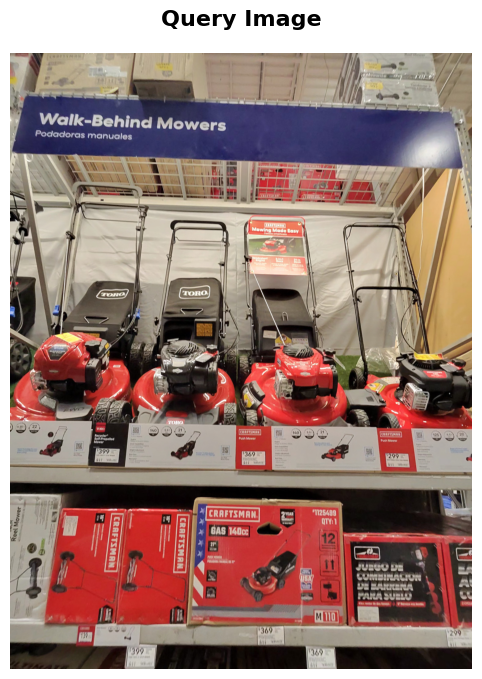

In [6]:
sample_example(task_dict, img_ds, sid2idx, task='qa')

## EDA: Ranker

3d755ff5-bce3-4dac-b66d-2f93e07cbee3


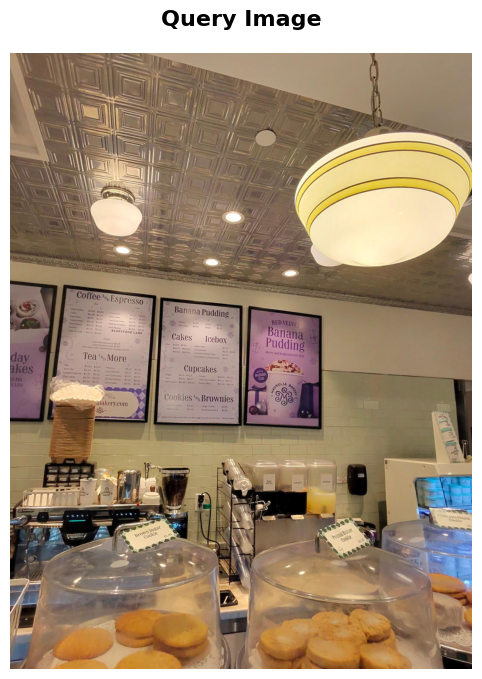

In [7]:
sample_example(task_dict, img_ds, sid2idx, task='ranker')

## EDA: Query Writing

0a13288b-0e01-4b7a-91f4-d4dddb6106f3


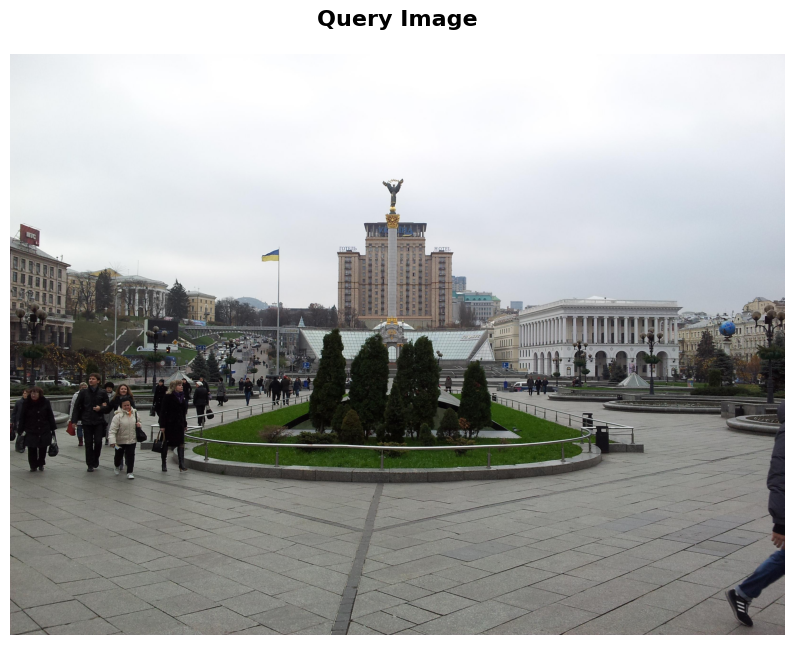

In [8]:
sample_example(task_dict, img_ds, sid2idx, task='query_gen')